In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchinfo
from torchvision import transforms
from torch import nn

In [5]:
from going_modular.going_modular import data_setup,engine


In [6]:
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
import os
from pathlib import Path
data_path = Path('../Datasets/')
image_path = data_path/'pizza_steak_sushi'
image_path.is_dir()

True

In [9]:
train_dir = image_path/'train'
test_dir = image_path/'test'

In [10]:
normalize= transforms.Normalize(mean=[0.485,0.456,0.406],
                                std=[0.229,0.224,0.225])
manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [11]:
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=manual_transform,
                                                                           batch_size=32)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x20c6628e6d0>,
 ['pizza', 'steak', 'sushi'])

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=auto_transforms,
                                                                           batch_size=32)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x20c6629be90>,
 ['pizza', 'steak', 'sushi'])

In [15]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [18]:
from torchinfo import summary
summary(model = model,input_size=(1,3,224,224),col_names=['input_size','output_size','num_params','trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [19]:
for param in model.features.parameters():
    param.requires_grad=False

In [20]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = 0.001)

In [23]:
from going_modular.going_modular import engine
results = engine.train(model = model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

 10%|█         | 1/10 [00:18<02:49, 18.85s/it]

Epoch: 1 | train_loss: 1.0496 | train_acc: 0.5195 | test_loss: 0.9133 | test_acc: 0.6506


 20%|██        | 2/10 [00:37<02:30, 18.76s/it]

Epoch: 2 | train_loss: 0.8894 | train_acc: 0.5742 | test_loss: 0.7949 | test_acc: 0.7017


 30%|███       | 3/10 [00:55<02:09, 18.53s/it]

Epoch: 3 | train_loss: 0.7915 | train_acc: 0.6992 | test_loss: 0.6631 | test_acc: 0.8655


 40%|████      | 4/10 [01:13<01:48, 18.06s/it]

Epoch: 4 | train_loss: 0.6602 | train_acc: 0.8906 | test_loss: 0.6472 | test_acc: 0.8759


 50%|█████     | 5/10 [01:30<01:29, 17.91s/it]

Epoch: 5 | train_loss: 0.6604 | train_acc: 0.7773 | test_loss: 0.6337 | test_acc: 0.8153


 60%|██████    | 6/10 [01:49<01:12, 18.12s/it]

Epoch: 6 | train_loss: 0.5738 | train_acc: 0.8125 | test_loss: 0.5592 | test_acc: 0.8968


 70%|███████   | 7/10 [02:07<00:54, 18.23s/it]

Epoch: 7 | train_loss: 0.5687 | train_acc: 0.7930 | test_loss: 0.5662 | test_acc: 0.8248


 80%|████████  | 8/10 [02:25<00:36, 18.15s/it]

Epoch: 8 | train_loss: 0.4823 | train_acc: 0.9180 | test_loss: 0.5316 | test_acc: 0.8665


 90%|█████████ | 9/10 [02:44<00:18, 18.25s/it]

Epoch: 9 | train_loss: 0.4775 | train_acc: 0.8359 | test_loss: 0.4980 | test_acc: 0.8258


100%|██████████| 10/10 [03:02<00:00, 18.24s/it]

Epoch: 10 | train_loss: 0.4408 | train_acc: 0.9609 | test_loss: 0.4925 | test_acc: 0.8561


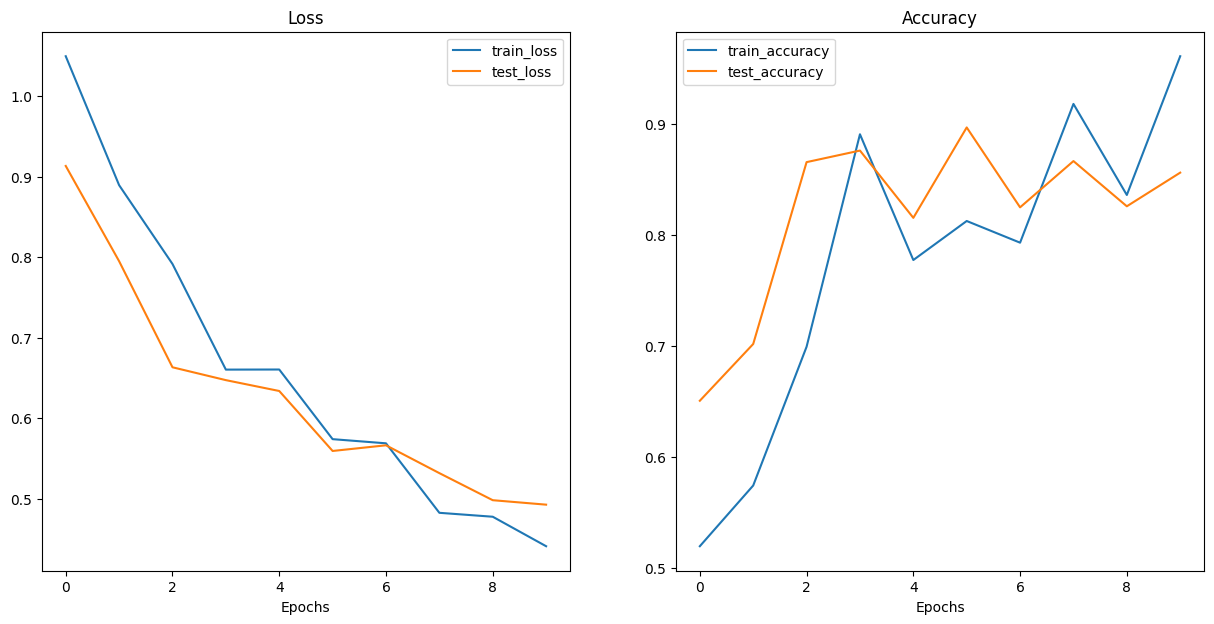

In [24]:
from going_modular.going_modular import helper_functions
helper_functions.plot_loss_curves(results=results)

In [25]:
from typing import List,Tuple
from PIL import Image

def pred_and_plot_image(model,image_path,class_names,image_size,transform,device):
    image = Image.open(image_path)
    if transform is not None:
        img_transform = transform
    else:
        img_transform = transforms.Compose(
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                std=[0.229,0.224,0.225])
        )
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_img = img_transform(image).unsqueeze(dim=0)
        target_image_pred = model(transformed_img.to(device))
        target_img_pred_probs = torch.softmax(target_image_pred,dim=1)
        targ_img_pred_label = torch.argmax(target_img_pred_probs,dim=1)
        plt.figure()
        plt.imshow(image)
        plt.title(class_names[targ_img_pred_label])
        plt.axis(False)

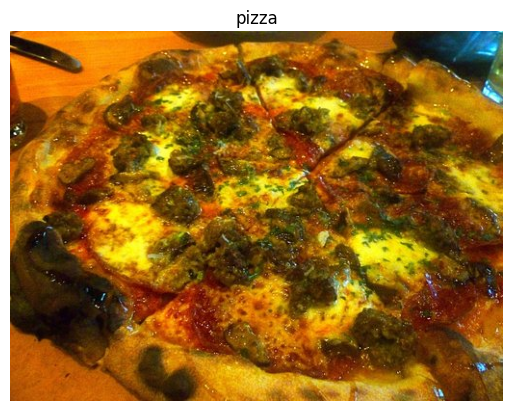

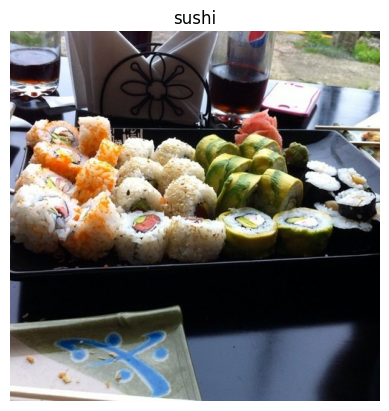

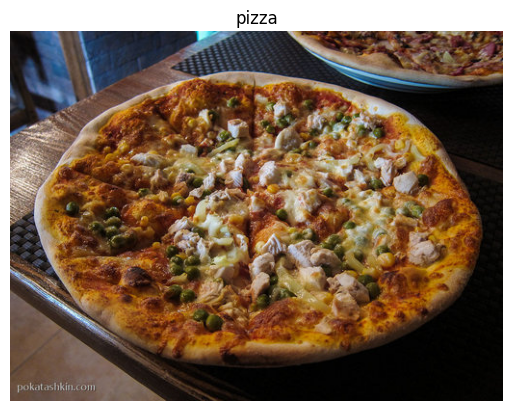

In [26]:
import random 
num_images_plot = 3
test_img_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_img_path_sample = random.sample(population=test_img_path_list,k=num_images_plot)
for image_path in test_img_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=auto_transforms,
                        image_size=(224,224),
                        device=device)